#Normalizing Skeleton -> Annotation File -> Run Coco Eval

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json

# Function to align and scale skeletons

def align_and_scale_skeletons_flat(flat_kp1, flat_kp2, spine_index=1):
    """
    Align and scale two skeletons based on a central keypoint (e.g., spine) for flattened keypoint arrays.

    Parameters:
        flat_kp1 (np.ndarray): First skeleton's keypoints in flat COCO 17 format.
        flat_kp2 (np.ndarray): Second skeleton's keypoints in flat COCO 17 format.
        spine_index (int): Index of the central spine keypoint (default: 1, as per COCO).

    Returns:
        scaled_flat_kp2 (np.ndarray): Keypoints of the second skeleton after alignment and scaling, in flat format.
    """
    def get_bounding_box(flat_kp):
        x_coords, y_coords = [], []
        for i in range(18):
            x, y, v = flat_kp[i * 3:(i * 3) + 3]
            if v > 0:
                x_coords.append(x)
                y_coords.append(y)
        if not x_coords or not y_coords:
            raise ValueError("No visible keypoints found.")
        return (min(x_coords), min(y_coords), max(x_coords), max(y_coords))

    def scale_keypoints(flat_kp, scale_w, scale_h, center):
        scaled = flat_kp.copy()
        for i in range(18):
            x, y, v = scaled[i * 3:(i * 3) + 3]
            if v > 0:
                scaled[i * 3] = center[0] + (x - center[0]) * scale_w
                scaled[i * 3 + 1] = center[1] + (y - center[1]) * scale_h
        return scaled

    center1 = flat_kp1[spine_index * 3:(spine_index * 3) + 2]
    center2 = flat_kp2[spine_index * 3:(spine_index * 3) + 2]

    aligned_flat_kp2 = flat_kp2.copy()
    for i in range(18):
        x, y, v = aligned_flat_kp2[i * 3:(i * 3) + 3]
        if v > 0:
            aligned_flat_kp2[i * 3] += (center1[0] - center2[0])
            aligned_flat_kp2[i * 3 + 1] += (center1[1] - center2[1])

    bbox1 = get_bounding_box(flat_kp1)
    bbox2 = get_bounding_box(aligned_flat_kp2)

    width1, height1 = bbox1[2] - bbox1[0], bbox1[3] - bbox1[1]
    width2, height2 = bbox2[2] - bbox2[0], bbox2[3] - bbox2[1]
    scale_w, scale_h = width1 / width2, height1 / height2

    scaled_flat_kp2 = scale_keypoints(aligned_flat_kp2, scale_w, scale_h, center1)

    return scaled_flat_kp2


# Function to extract (x, y) coordinates from a flattened array
def extract_coordinates(flat_keypoints):
    coords = []
    for i in range(18):
        x, y, v = flat_keypoints[i * 3:(i * 3) + 3]
        if v > 0:
            coords.append((x, y))
        else:
            coords.append(None)
    return coords

# Calculate bounding boxes
def get_bounding_box(keypoints):
    visible_points = [p for p in keypoints if p is not None]
    if not visible_points:
        return None
    x_coords, y_coords = zip(*visible_points)
    return min(x_coords), min(y_coords), max(x_coords) - min(x_coords), max(y_coords) - min(y_coords)

# Flatten keypoints from 2D keypoint arrays
def flatten_keypoints_2d(keypoints_2d):
    flattened_keypoints = []
    for idx, kp in enumerate(keypoints_2d):
        flattened_keypoints.extend([kp[0], kp[1], 2])
    #return np.array(flattened_keypoints)
    return flattened_keypoints

# Function to create the annotation for a single set of keypoints
def create_annotation(image_id, category_id, keypoints, score):
    del keypoints[3]
    del keypoints[4]
    del keypoints[5]
    return {
        "image_id": image_id,
        "category_id": category_id,
        "keypoints": keypoints,
        "score": score
    }

# function to create gt ann
def create_gt_annotation(image_id, category_id, keypoints, bounding_box, area):
    del keypoints[3]
    del keypoints[4]
    del keypoints[5]
    return {
        "id": 1,
        "image_id": image_id,
        "category_id": category_id,
        "keypoints": keypoints,
        "num_keypoints": len(keypoints) // 3,  # Assuming each keypoint has x, y, visibility
        "area": area,
        "bbox": bounding_box,  # The bounding box for the keypoints
        "iscrowd": 0
    }

In [43]:
def plotting_skeletons(keypoints_2d_1, keypoints_2d_2, bounding_box_1, bounding_box_2):
  plt.figure(figsize=(10, 15))

  for point in keypoints_2d_1:
      if point is not None:
          plt.scatter(point[0], point[1], c='red', s=50)

  for point in keypoints_2d_2:
      if point is not None:
          plt.scatter(point[0], point[1], c='green', s=50)

  if bounding_box_1:
      x, y, w, h = bounding_box_1
      plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))

  if bounding_box_2:
      x, y, w, h = bounding_box_2
      plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=2))

  plt.gca().invert_yaxis()
  plt.title("Skeletons with Bounding Boxes")
  plt.show()

In [44]:
#--------------------------------------------------------------------------------Main code--------------------------------------


def main_loop(keypoints_2d_1, keypoints_2d_2):
  flat_kp1 = flatten_keypoints_2d(keypoints_2d_1)
  flat_kp2 = flatten_keypoints_2d(keypoints_2d_2)
  #print("flat1", flat_kp1)
  #print("flat2", flat_kp2)

  scaled_flat_kp2 = align_and_scale_skeletons_flat(flat_kp1, flat_kp2)
  #print("flat2scaled", scaled_flat_kp2)

  keypoints_2d_1 = extract_coordinates(flat_kp1)
  keypoints_2d_2 = extract_coordinates(scaled_flat_kp2)

  #TODO - get bounding box from ZED instead of calculating ourselves.
  bounding_box_1 = get_bounding_box(keypoints_2d_1)
  bounding_box_2 = get_bounding_box(keypoints_2d_2)

  plotting_skeletons(keypoints_2d_1, keypoints_2d_2, bounding_box_1, bounding_box_2)
  '''plt.figure(figsize=(10, 15))

  for point in keypoints_2d_1:
      if point is not None:
          plt.scatter(point[0], point[1], c='red', s=50)

  for point in keypoints_2d_2:
      if point is not None:
          plt.scatter(point[0], point[1], c='green', s=50)

  if bounding_box_1:
      x, y, w, h = bounding_box_1
      plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))

  if bounding_box_2:
      x, y, w, h = bounding_box_2
      plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=2))

  plt.gca().invert_yaxis()
  plt.title("Skeletons with Bounding Boxes")
  plt.show()'''

  #--------------------------------------------------------------------------------------
  #Create gt ann

  # Path to the ground truth JSON file
  ground_truth_file = "ground_truth.json"

  # # Load existing ground truth JSON file
  # with open(ground_truth_file, "r") as f:
  #     ground_truth = json.load(f)

  # # Get the next available annotation ID (increment the last existing annotation ID)
  # if ground_truth["annotations"]:
  #     next_annotation_id = max(ann["id"] for ann in ground_truth["annotations"]) + 1
  # else:
  #     next_annotation_id = 1  # Start from 1 if no annotations exist

  # Create a new annotation for flat_kp1
  '''gt_annotations = [create_gt_annotation(
      image_id=1,
      category_id=1,
      keypoints=flat_kp1,
      bounding_box=bounding_box_1,
      annotation_id=1, #always only 1 annot?
      area=bounding_box_1[2] * bounding_box_1[3]  # area = width * height
  )]
  ground_truth_file = "ground_truth.json"
  with open(ground_truth_file, "w") as f:
      json.dump(gt_annotations, f, indent=4)

  print(f"Annotations have been saved to {ground_truth_file}")'''
  # Structure of the ground truth JSON file
  ground_truth = {
      "info": {},
      "licenses": [],
      "images": [
          {"id": 1, "width": 1080, "height": 920, "file_name": "image1.jpg"}
      ],
      "annotations": [
          create_gt_annotation(
              image_id=1,
              category_id=1,
              keypoints=flat_kp1,
              bounding_box=bounding_box_1,
              area=bounding_box_1[2] * bounding_box_1[3]  # area = width * height
          )
      ],
      "categories": [
          {"id": 1, "name": "person", "supercategory": "person", "keypoints": [
              "nose", "left_eye", "right_eye", "left_ear", "right_ear",
              "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
              "left_wrist", "right_wrist", "left_hip", "right_hip",
              "left_knee", "right_knee", "left_ankle", "right_ankle"
          ]}
      ]
  }

  # Path to the ground truth JSON file
  ground_truth_file = "gt_ann.json"

  # Write the ground truth JSON file
  with open(ground_truth_file, "w") as f:
      json.dump(ground_truth, f, indent=4)

  print(f"Ground truth has been saved to {ground_truth_file}")

  # Read and print the contents of the JSON file
  with open(ground_truth_file, "r") as f:
      data = json.load(f)
      print(json.dumps(data, indent=4))  # Pretty print the JSON data
  #--------------------------------------------------------------------------------------
  # Create annotations for each set of keypoints
  annotations = [
      create_annotation(image_id=1, category_id=1, keypoints=scaled_flat_kp2, score=0.92)
  ]

  # Write the annotations to a JSON file
  output_file = "detect_ann.json"
  with open(output_file, "w") as f:
      json.dump(annotations, f, indent=4)

  print(f"Annotations have been saved to {output_file}")

  # Read and print the contents of the JSON file
  with open(output_file, "r") as f:
      data = json.load(f)
      print(json.dumps(data, indent=4))  # Pretty print the JSON data


In [51]:
#run coco eval


def run_coco_eval():
  # Paths to your files
  ground_truth_file = "gt_ann.json"
  detection_file = "detect_ann.json"

  # Initialize COCO ground truth and detection
  coco_gt = COCO(ground_truth_file)
  coco_dt = coco_gt.loadRes(detection_file)

  # Check lengths of keypoints in ground truth
  for annotation in coco_gt.dataset['annotations']:
      print(f"Ground Truth Keypoints Length: {len(annotation['keypoints'])}")

  # Check lengths of keypoints in detections
  for detection in coco_dt.anns.values():
      print(f"Detection Keypoints Length: {len(detection['keypoints'])}")
      if any(kp % 3 == 2 and kp not in [0, 1, 2] for kp in annotation['keypoints']):
          print(f"Invalid visibility flag in ground truth ID {annotation['id']}")

  # Check for mismatched keypoints
  for detection in coco_dt.anns.values():
      if len(detection['keypoints']) != 51:  # 17 keypoints * 3 (x, y, visibility)
          print(f"Detection ID {detection['id']} has {len(detection['keypoints'])} keypoints.")

  for detection in coco_dt.anns.values():
      print(f"Detection ID {detection['id']} Score: {detection['score']}")


  # Initialize COCOeval
  coco_eval = COCOeval(coco_gt, coco_dt, iouType="keypoints")

  # Set maxDets to 50
  #coco_eval.params.maxDets = [5]  # Set maxDets to 5

  # Print to confirm
  #print("Max Dets:", coco_eval.params.maxDets)

  # Specify the image IDs you want to evaluate (or use all available in the ground truth)
  image_ids = sorted(coco_gt.getImgIds())

  # Run evaluation
  coco_eval.params.imgIds = image_ids
  coco_eval.evaluate()
  coco_eval.accumulate()
  coco_eval.summarize()

  # Extract the first AP value
  average_precision = coco_eval.stats[0]  # This corresponds to AP @[ IoU=0.50:0.95 | area=all | maxDets=20 ]
  print(f"Ingrid Check Average Precision (AP) = {average_precision}")
  return average_precision


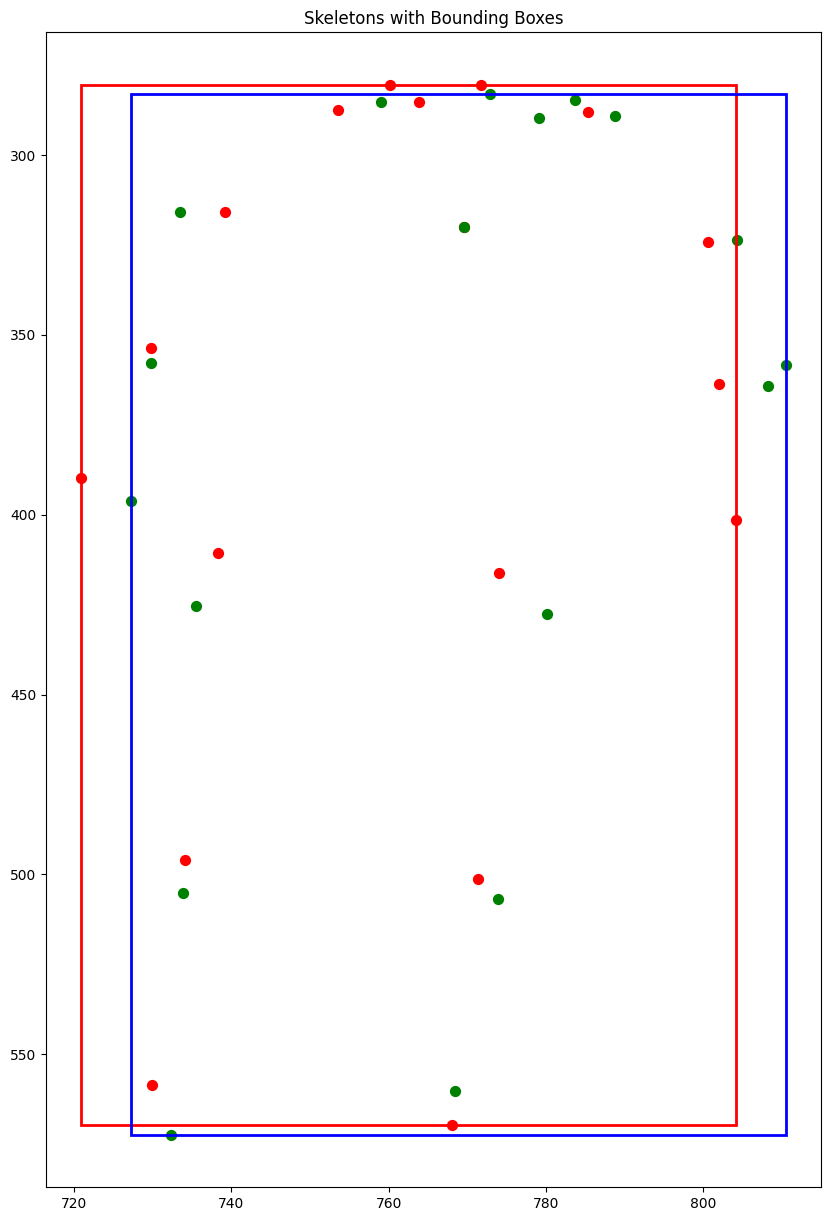

Ground truth has been saved to gt_ann.json
{
    "info": {},
    "licenses": [],
    "images": [
        {
            "id": 1,
            "width": 1080,
            "height": 920,
            "file_name": "image1.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 1,
            "keypoints": [
                763.84375,
                285.37832642,
                2,
                319.89837646,
                739.19055176,
                2,
                729.74664307,
                353.73120117,
                2,
                720.88989258,
                389.87475586,
                2,
                800.57299805,
                324.07250977,
                2,
                802.06512451,
                363.5302124,
                2,
                804.22729492,
                401.43383789,
                2,
                738.26086426,
                410.6293335,
                2,


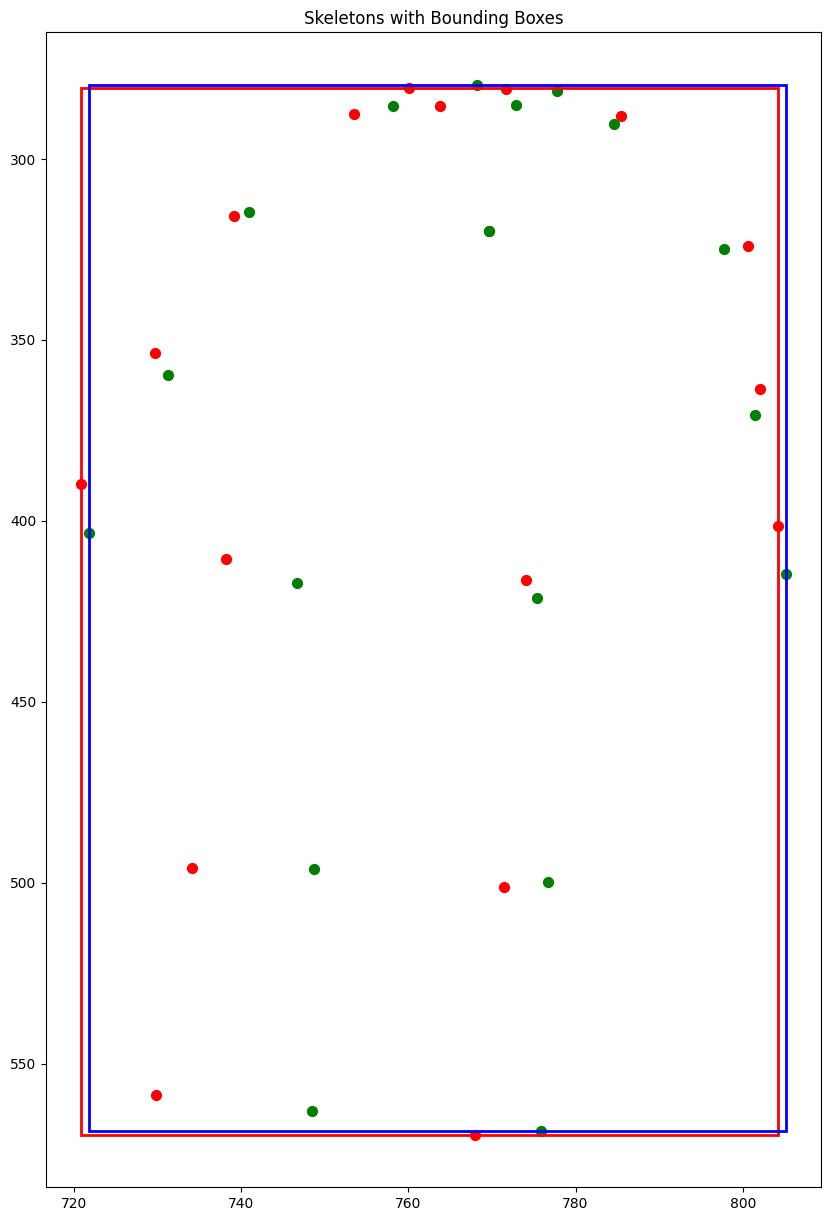

Ground truth has been saved to gt_ann.json
{
    "info": {},
    "licenses": [],
    "images": [
        {
            "id": 1,
            "width": 1080,
            "height": 920,
            "file_name": "image1.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 1,
            "keypoints": [
                763.84375,
                285.37832642,
                2,
                319.89837646,
                739.19055176,
                2,
                729.74664307,
                353.73120117,
                2,
                720.88989258,
                389.87475586,
                2,
                800.57299805,
                324.07250977,
                2,
                802.06512451,
                363.5302124,
                2,
                804.22729492,
                401.43383789,
                2,
                738.26086426,
                410.6293335,
                2,


In [53]:
#----------------------------------------------------Driver code-------------------------------------------
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
NUM_PARTICIPANTS = 6

def main():
  # Sample 2D keypoints

  keypoints_2d_1 = [
      [763.84375, 285.37832642],
      [769.61334229, 319.89837646],
      [739.19055176, 315.79663086],
      [729.74664307, 353.73120117],
      [720.88989258, 389.87475586],
      [800.57299805, 324.07250977],
      [802.06512451, 363.5302124],
      [804.22729492, 401.43383789],
      [738.26086426, 410.6293335],
      [734.14788818, 496.0484314],
      [729.84399414, 558.59570312],
      [774.0682373, 416.28106689],
      [771.40209961, 501.16693115],
      [768.03521729, 569.67388916],
      [760.1305542, 280.47171021],
      [771.69519043, 280.60391235],
      [753.53033447, 287.54129028],
      [785.41778564, 288.09906006]
  ]

  keypoints_2d_2 = [
      [399.12997437 ,305.73544312],
      [392.01922607 ,329.26657104],
      [365.07073975 ,326.15209961],
      [362.32302856 ,358.77740479],
      [360.36807251 ,388.66491699],
      [417.88824463 ,332.2562561 ],
      [420.84381104 ,363.815979  ],
      [422.53997803 ,359.37200928],
      [366.60964966 ,411.51760864],
      [365.30502319, 473.81097412],
      [364.19903564 ,526.12854004],
      [399.89993286, 413.20977783],
      [395.24258423 ,474.9335022 ],
      [391.13439941, 516.6038208 ],
      [394.48440552, 300.61260986],
      [402.50976562, 301.73754883],
      [384.09439087, 302.30859375],
      [406.32385254, 305.35794067]
  ]
  keypoints_2d_3 =  [
    [586.3581543,  312.33065796],
    [583.33056641, 336.78881836],
    [557.20043945, 333.14569092],
    [548.34942627, 364.61724854],
    [539.71374512, 395.28616333],
    [608.97998047, 340.36489868],
    [612.37384033, 372.35391235],
    [615.74243164, 403.22262573],
    [562.44171143, 404.95120239],
    [564.25061035, 460.30383301],
    [564.0178833 , 507.13412476],
    [588.57092285, 407.80569458],
    [589.75769043, 462.76037598],
    [589.00732422, 511.11193848],
    [582.06915283, 308.4866333 ],
    [590.76654053, 309.75595093],
    [572.84533691, 312.52529907],
    [596.95947266, 316.00613403]
  ]

  #TODO - loop with incoming ZED data (loop per gt / per frame)
  vals = []
  main_loop(keypoints_2d_1, keypoints_2d_2)
  vals.append(run_coco_eval())
  main_loop(keypoints_2d_1, keypoints_2d_3)
  vals.append(run_coco_eval())
  print("ingrid final detect vals for this gt skeleton", vals)


if __name__ == "__main__":
  main()